<a href="https://colab.research.google.com/github/unguyen14/customer_churn/blob/main/Telco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author: Winnie Nguyen**

---


# Telecom Customer Churn Analysis

- Custormer attention is essential for many businesses, especially in the era in which many options are offered to them at competitive prices. Therefore, it is important to identify customers so that necessary efforts can be diverted in a targeted and purposeful manners to maximize the efficiency. 
- In this analysis, a small dataset of churned customers for a telecom company with different collected features will be analyzed, in order to build a predictive model that can help early dectection of customers who are likely to stop using the service.


# 0. Preprocessing
- The dataset is obtained from Kaggle. The following steps will access the dataset using API credential. 

In [ ]:
 ! pip install -q kaggle

In [ ]:
#upload your api file
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d blastchar/telco-customer-churn

  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 54.5MB/s]


In [ ]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


# 1. Import Dataset and Initial Data Cleansing

In [ ]:
#Import all libraries that will be used in the notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
#Read file to a dataframe
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Comments:
- The size of the dataset is 7043 records.
  - The target variable is 'Churn,' which is has 2 values: "Yes" and "No."
  - The rest of the columns are 20 features that will be used to predict the target variable. 
- Additional data cleansing steps that can be inferred before we proceed are:    
  - 'customerID' should be excluded because of the irrelevancy as well as privacy. 
  - 'TotalCharges' is in incorrect format, and needs to be changed to float. 
  - generating dummies for all categorical variables for processing. 

In [ ]:
#drop unnecessary column 'customerID'
df.drop('customerID', axis=1,inplace=True)

The steps to change types of 'TotalCharges' involve:
  - stripping off the spaces if there are any in the strings
  - changing the type to numeric
  - checking for NA values after changing the type
  - dropping NA values if there are any

In [ ]:
#change type of 'TotalCharges'
df.TotalCharges= df.TotalCharges.apply(lambda x: x.strip())
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges.isna().sum()

11

In [ ]:
#drop na, reset index
df=df.dropna()
df.reset_index(drop=True, inplace=True)
df.TotalCharges.isna().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


### Comments:
- After finishing all the initial data cleansing, the dataset is the sample of 7032 data points, with 19 features and 1 target variable. 

## Dealing with Categorical and Numerical Data
- In this step, categorical and numerical variables are obtained for further usage convenience.  
- In order to proceed with further analysis, dummies are generated for categorical variables, without using drop_first so that all information can be preserved for feature selection.

In [ ]:
#find categorical data
cat_col = df.select_dtypes('object').columns
non_cat_col = df.select_dtypes(exclude=['object'])
print(cat_col)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [ ]:
#generate dummies for both
dummies = pd.get_dummies(df[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod',  'Churn']],
                         prefix = cat_col)

#Join dummies with original data in a new dataframe
df_train=df.join(dummies)
#Show dataframe
df_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0
7028,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
7029,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
7030,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1


# 2. Exploratory Data Analysis
- In this step, we will focus on discovering the features and their relationships with our target variable, in order to find patterns and potential outliers that are likely to affect the models. 

## 2.1 Numerical variables

In [ ]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


In [ ]:
def count_plot_cat(variable_name, dataf):
    df_draw=(dataf.groupby([variable_name]))['Churn_Yes'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index()
    g = sns.barplot(x=variable_name,y='Percentage',hue='Churn_Yes',data=df_draw)
    plt.title('Count plot ' + variable_name)
    plt.show()

def count_plot_numeric(variable_name):
    sns.barplot(x=variable_name, y=variable_name, data=df_train, estimator=lambda x: len(x) / len(df) * 100)
    plt.ylabel("Percent")
    plt.show()

# Lastly, set a few properties for sns
sns.set(style='darkgrid', palette="mako", font_scale=1.1, rc={"figure.figsize": [8, 5]})

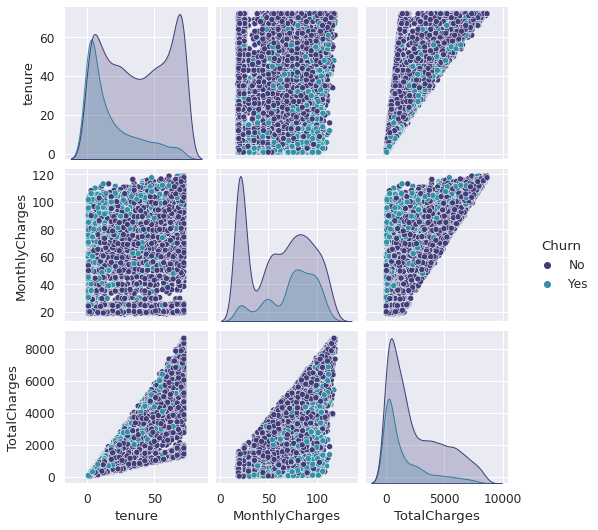

In [ ]:
palette ={"No": "C1", "Yes": "C3"}
sns.pairplot(data=df.drop('SeniorCitizen', axis=1), hue="Churn", palette=palette)

## 2.2 Categorical variables

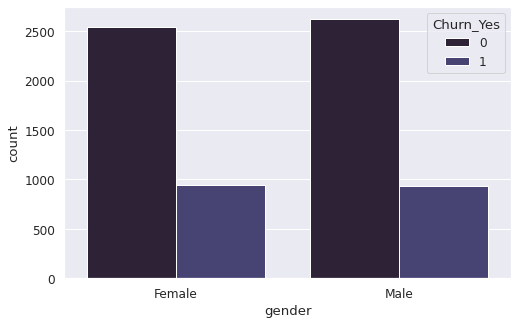

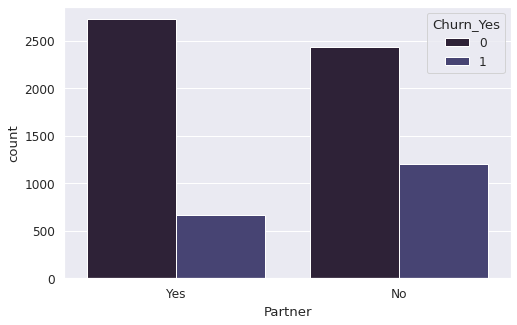

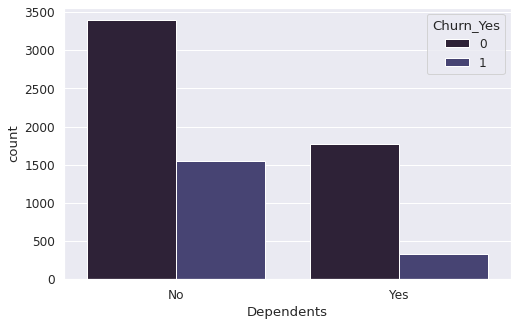

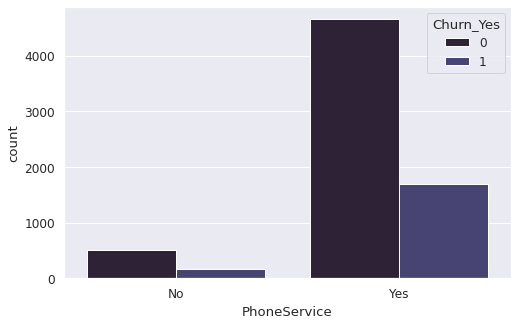

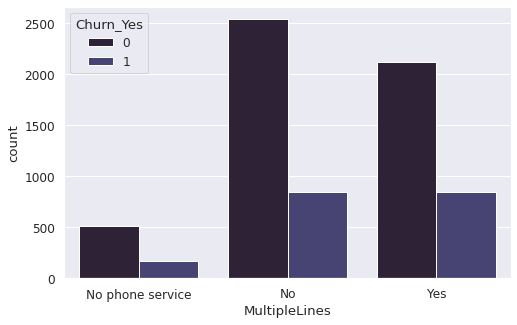

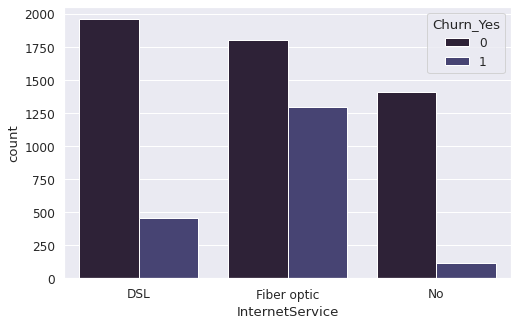

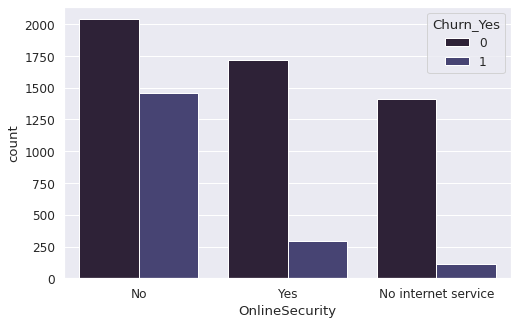

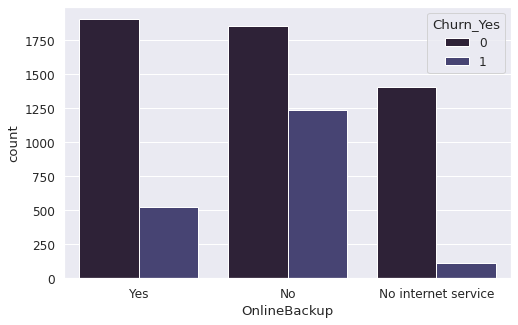

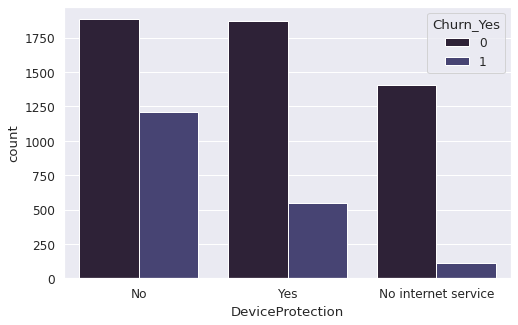

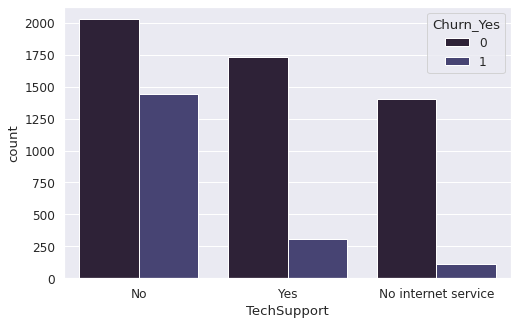

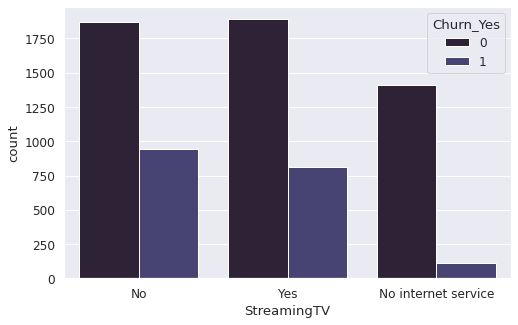

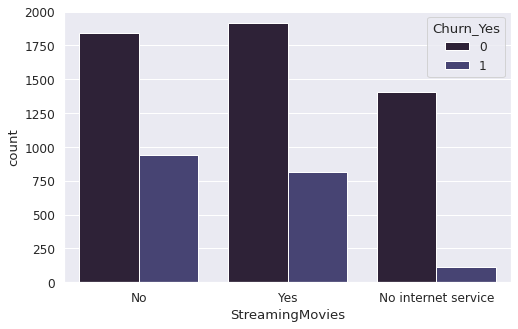

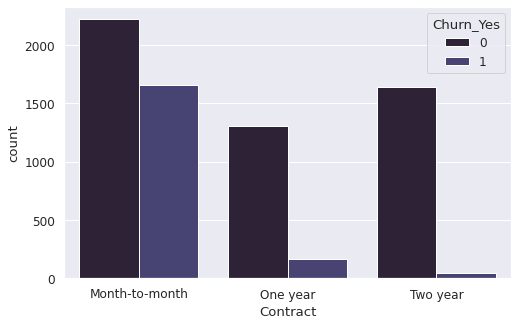

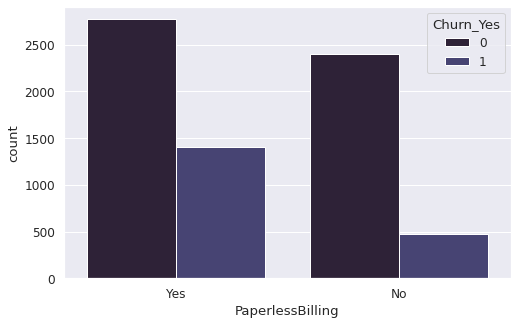

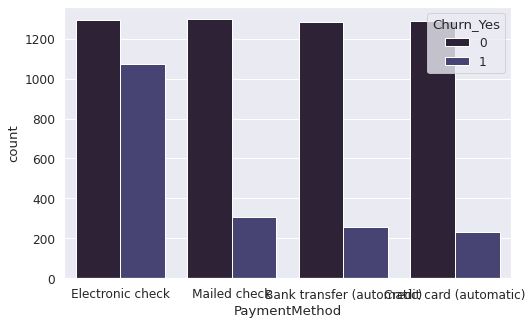

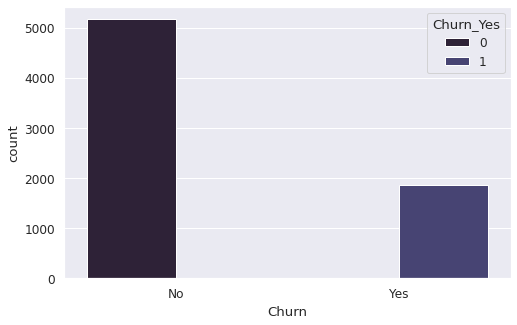

In [ ]:
for i in cat_col:
  sns.countplot(hue="Churn_Yes", x=i, data=df_train)
  plt.show()

In [ ]:
df_train=df_train.drop(columns=cat_col, axis=1)

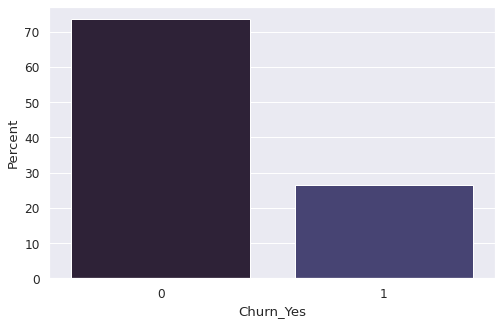

In [ ]:
count_plot_numeric("Churn_Yes")

### Comments:
- About 28% of customers stopped using the services.
- Because the data is skewed towards customers who still use the service, we will resample to make the data more balanced.


In [ ]:
df_train=df_train.drop(columns=['Churn_No'], axis=1)

In [ ]:
df_train.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', '

In [ ]:
features = df_train.drop(columns=['Churn_Yes'])
responses = df_train['Churn_Yes']

# 3. Feature Selection
- The first step is to rebalance the dataset to make it more balanced with RandomOverSampler.
- To choose the most relevant set of features to train data, 4 feature selection methods will be used, including 
  - LinearSVC with SelectFromModel
  - LogisticRegreession with SelectFromModel
  - RandomForest with SelectFromModel
  - SelectKBest with default k=10 using mutual_info_classif parameter

## 3.1 Rebalance the dataset with RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# define resampling
rus = RandomOverSampler(random_state=42)
# fit predictor and target variable
features_ros_ar, response_ros_ar = rus.fit_resample(features, responses)

#put the features and response np.array to dataframe
features_ros = pd.DataFrame(features_ros_ar, columns=features.columns)
response_ros = pd.DataFrame(response_ros_ar, columns=['Churn_Yes'])

print('Original dataset:', responses.describe(), "\n")
print('Resample dataset', response_ros.describe())

#set sample set to use for training model
features = features_ros
responses = response_ros.squeeze()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Original dataset: count    7032.000000
mean        0.265785
std         0.441782
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn_Yes, dtype: float64 

Resample dataset           Churn_Yes
count  10326.000000
mean       0.500000
std        0.500024
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Comments:
- Our new sample contains 10,326 data points, with the number of churned and active customers being more balanced, which will assist the prediction of our models in later stages.  

In [ ]:
#import libraries
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif,SelectFromModel
from matplotlib import pyplot
from sklearn.svm import LinearSVC

In [ ]:
#select feature with LinearSVC
selector_svm = SelectFromModel(estimator=LinearSVC(dual=False,max_iter=10000,C=0.001)).fit(features, responses)
svm_col=features.columns[selector_svm.get_support(indices=True)].tolist()

#get name in list
print(svm_col, "\nTotal features selected using SVM", len(svm_col))
features_svm = features[svm_col].copy()

['SeniorCitizen', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'TechSupport_No', 'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'] 
Total features selected using SVM 19


In [ ]:
#select feature with logisticsregression
selector_logistic = SelectFromModel(estimator=LogisticRegression(max_iter=5000))
selector_logistic.fit(features, responses)
#get name in list
log_col=features.columns[selector_logistic.get_support(indices=True)].tolist()
print(log_col, "\nTotal features selected using LogisticRegression", len(log_col))
features_log = features[log_col].copy()

['SeniorCitizen', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'TechSupport_No', 'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check'] 
Total features selected using LogisticRegression 17


In [ ]:
#select features with randomforest
rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, random_state=42)
selector_rf = SelectFromModel(estimator=rf)

selector_rf.fit(features, responses)
selector_rf.threshold_
#get name in list
rf_col=features.columns[selector_rf.get_support(indices=True)].tolist()
print(rf_col, "\nTotal features selected using RandomForest:", len(rf_col))
features_rf=features[rf_col].copy()

['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check'] 
Total features selected using RandomForest: 9


In [ ]:
#SelectKBest with mutual_info_classif
selector_k = SelectKBest(mutual_info_classif)
X_new = selector_k.fit_transform(features, responses)
print(X_new)
#get name in list
k_col=features.columns[selector_k.get_support(indices=True)].tolist()
print(k_col,"\nTotal features selected using SelectKBest:",len(k_col))
features_k = features[k_col].copy()

[[1.0000e+00 2.9850e+01 2.9850e+01 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [3.4000e+01 5.6950e+01 1.8895e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0000e+00 5.3850e+01 1.0815e+02 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [4.6000e+01 9.3700e+01 4.1548e+03 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [3.0000e+00 3.4250e+01 1.3935e+02 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [2.0000e+00 9.5850e+01 1.9770e+02 ... 1.0000e+00 0.0000e+00 1.0000e+00]]
['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'StreamingMovies_No internet service', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check'] 
Total features selected using SelectKBest: 10


In [ ]:
#sert a dict with feature sets
features_group = {'LogisticRegression': features_log, 'LinearSVM': features_svm, 'SelectKBest': features_k, 'RandomForest': features_rf}

## 3.3 Test Features Sets to choose best features set
- In this step, we will choose features based on their average performance in 3 simple models. 

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [ ]:
# #Names of the various classification approaches for easy presentation of the results
names = ["Logistic Regression", "LinearSVC", "Decision Tree"]

#Create a dataframe for prediction scores
scores_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Params', 'Feature_Selection', "Num_Features"])

for key, curr_features in features_group.items():
    print("Processing CV for feature selection evaluation - features selected by: ", key)
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, responses, 
                                                        test_size=0.25, 
                                                        random_state=42)

    #scaling:
    scaling=[RobustScaler()]

    #list of classifiers
    classifiers = [
        LogisticRegression(),
        SVC(kernel="linear", probability=True),
        DecisionTreeClassifier(max_depth=5),    
    ]

    #hyperparameters for cv
    param_grid = [
        {'classifier__max_iter': [1000,100]},
        {'classifier__C': [0.001, 0.01, 0.1, 1, 10]},
        {'classifier__min_samples_leaf': [1, 5]}
    ]

    #Create kfold object
    kfold = KFold(n_splits=5)

    #match the classifier and hyperparams
    for index, classifier in enumerate(classifiers):
        steps=[('scaler', RobustScaler()),('classifier', classifier)]
        pipeline=Pipeline(steps)
        cv = GridSearchCV(pipeline, param_grid=param_grid[index], cv=kfold, scoring='accuracy')
        cv.fit(X_train, Y_train)
        # check out best model performance
        scores_df = scores_df.append({'Classifier': names[index], 'Accuracy': cv.best_score_, 'Params': cv.best_params_, 'Feature_Selection': key, "Num_Features" :len(curr_features.columns)}, ignore_index=True)

scores_df

Processing CV for feature selection evaluation - features selected by:  LogisticRegression
Processing CV for feature selection evaluation - features selected by:  LinearSVM
Processing CV for feature selection evaluation - features selected by:  SelectKBest
Processing CV for feature selection evaluation - features selected by:  RandomForest


,Classifier,Accuracy,Params,Feature_Selection,Num_Features
0,Logistic Regression,0.750000,{'classifier__max_iter': 1000},LogisticRegression,17
1,LinearSVC,0.746771,{'classifier__C': 0.001},LogisticRegression,17
2,Decision Tree,0.749224,{'classifier__min_samples_leaf': 1},LogisticRegression,17
3,Logistic Regression,0.748967,{'classifier__max_iter': 1000},LinearSVM,19
4,LinearSVC,0.745351,{'classifier__C': 0.1},LinearSVM,19
5,Decision Tree,0.748579,{'classifier__min_samples_leaf': 1},LinearSVM,19
6,Logistic Regression,0.765755,{'classifier__max_iter': 1000},SelectKBest,10
7,LinearSVC,0.755553,{'classifier__C': 0.01},SelectKBest,10
8,Decision Tree,0.768078,{'classifier__min_samples_leaf': 1},SelectKBest,10
9,Logistic Regression,0.765496,{'classifier__max_iter': 1000},RandomForest,9


In [ ]:
results_group = scores_df.groupby(['Feature_Selection']).mean()
results_group = results_group.sort_values(by=['Accuracy'], ascending=False)
results_group

,Accuracy
Feature_Selection,
RandomForest,0.763215
SelectKBest,0.763129
LogisticRegression,0.748665
LinearSVM,0.747632


### Comment:
- With 10 features, SelectKBest is the best performing set based on average score. Therefore, we proceed with this set of features

# 4. Simple Classification Methods with Hyperparameters Tuning:
- Using the previous chosen feature set, we will apply some classification algorithms, with GridSearchCV to tune their hyperparameters.  

In [ ]:
#set features to use 
features = features_k

#define scaler
scaler = RobustScaler()

#fit data
transformed = scaler.fit_transform(features)

#create df again
features_rs = pd.DataFrame(transformed, index=features.index, columns = features.columns)
features_rs = features_rs.reset_index(drop=True)

In [ ]:
#Separate the data
X_train, X_test, Y_train, Y_test = train_test_split(features_rs, responses, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
# scores = [] #list variable to hold classification scores
# #Names of the various classification approaches for easy presentation of the results
names = ["LinearSVC", "DecisionTree", "RandomForest", "AdaBOOST", "XGBOOST"]

#Create a dictionary to hold best parameters
best_params = dict()

#XGBOOST vars
best_es = 0
best_score_xg=0

#list of classifiers
classifiers = [
    SVC(kernel="linear", probability=True),
    DecisionTreeClassifier(),    
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric="error")]

#hyperparameters for cv
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    {'min_samples_leaf': [1, 5], 'max_depth': np.arange(5,10,1)},
    {'n_estimators': list(range(10, 1000, 200)),  'max_leaf_nodes' : np.arange(15,20,1) },
    {'learning_rate': [0.01, 0.1, 1]},
    {'early_stopping_rounds': list(range(2,20))}
]

#Create kfold object
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

#match the classifier and hyperparams
for index, classifier in enumerate(classifiers):
    print("Processing CV for hyperparameter tuning:", names[index])
    #if it's not XGBoost, perform GridSearch
    if names[index] != "XGBOOST":
        cv = GridSearchCV(classifier, param_grid[index], cv=kfold, scoring='accuracy')
        cv.fit(X_train, Y_train)
        # check out best model performance
        best_params[names[index]] = cv.best_params_
    else:
        #tune early stopping round with value in range 1-20
        for i in range(1,20,1):
            xgb =classifiers[index] 
            xgb.fit(X_train, Y_train, eval_set=[(X_test,Y_test)], eval_metric="error",verbose=False,early_stopping_rounds=i)
            Y_pred=xgb.predict(X_test)
            score = (accuracy_score(Y_test, Y_pred))
            if score>best_score_xg:
                best_score_xg=score
                best_es = i
        best_params[names[index]] = {"early_stopping_rounds": best_es}

print()
print("Best parameters:")

best_params

Processing CV for hyperparameter tuning: LinearSVC
Processing CV for hyperparameter tuning: DecisionTree
Processing CV for hyperparameter tuning: RandomForest
Processing CV for hyperparameter tuning: AdaBOOST
Processing CV for hyperparameter tuning: XGBOOST

Best parameters:


{'AdaBOOST': {'learning_rate': 1},
 'DecisionTree': {'max_depth': 9, 'min_samples_leaf': 1},
 'LinearSVC': {'C': 0.01},
 'RandomForest': {'max_leaf_nodes': 18, 'n_estimators': 10},
 'XGBOOST': {'early_stopping_rounds': 10}}

In [ ]:
#Names of the various classification approaches for easy presentation of the results
names = [ "LinearSVC", "DecisionTree", "RandomForest", "AdaBOOST","XGBOOST"]

#Create a dataframe for prediction scores
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Params', 'Feature_Selection'])

scores = [] #list variable to hold classification scores (predictive accuracy scores)

#Prepare models for VotingClassifier 
#creeate instances (i.e., objects) of the various classifiers, using the dictionary of "Best parameters" established on the previous item

linear_svc = SVC(kernel="linear", **best_params["LinearSVC"], probability=True)
dtc = DecisionTreeClassifier( **best_params["DecisionTree"])
rf = RandomForestClassifier( **best_params["RandomForest"], random_state=42)
ada = AdaBoostClassifier(**best_params["AdaBOOST"])
xgb = XGBClassifier(use_label_encoder=False, eval_metric="error")


classifiers = [
    linear_svc,
    dtc,
    rf,
    ada,
    xgb]

#run classification models using Pipeline
for index, classifier in enumerate(classifiers):
    print("Processing classifier:", names[index])
    #if it's not XGBoost, add model to pipeline
    if names[index] != "XGBOOST":
        pipeline = Pipeline(steps=[
                      ('classifier', classifier)])
        pipeline.fit(X_train, Y_train)
        results_df = results_df.append({'Classifier': names[index], 'Accuracy': pipeline.score(X_test, Y_test), 'Params': str(best_params[names[index]]), 'Feature_Selection': "RandomForest"}, ignore_index=True)
    #For XGBoost, set earlystoppingrounds
    else:
        xgb =classifiers[index] 
        xgb.fit(X_train, Y_train, eval_set=[(X_test,Y_test)], eval_metric="error",verbose=False,**best_params["XGBOOST"])
        Y_pred=xgb.predict(X_test)
        score = (accuracy_score(Y_test,Y_pred))
        results_df = results_df.append({'Classifier': names[index], 'Accuracy': score, 'Params': str(best_params[names[index]]), 'Feature_Selection': "RandomForest"}, ignore_index=True)

results_df = results_df.sort_values(by=['Accuracy'], ascending=False)
results_df

Processing classifier: LinearSVC
Processing classifier: DecisionTree
Processing classifier: RandomForest
Processing classifier: AdaBOOST
Processing classifier: XGBOOST


,Classifier,Accuracy,Params,Feature_Selection
1,DecisionTree,0.789698,"{'max_depth': 9, 'min_samples_leaf': 1}",RandomForest
3,AdaBOOST,0.766847,{'learning_rate': 1},RandomForest
2,RandomForest,0.761038,"{'max_leaf_nodes': 18, 'n_estimators': 10}",RandomForest
4,XGBOOST,0.759489,{'early_stopping_rounds': 10},RandomForest
0,LinearSVC,0.751743,{'C': 0.01},RandomForest


# 5. Ensemble Methods:
- Applying 'wisdom of the crowd' is believed to yield more accurate results since they can improve each other's weaknesses. Therefore, we will experimented with SoftVoting and HardVoting of 2 combinations:
  - All tuned models above
  - Best performing 3 models


In [ ]:
from sklearn.model_selection import cross_val_score
#Names of the various classification approaches for easy presentation of the results
names = ["HardVoting", "SoftVoting"]

#vars to record best results
best_voting_accuracy = {"HardVoting": 0, "SoftVoting": 0}
best_voters = {"HardVoting": [], "SoftVoting": []}

#Prepare models for VotingClassifier 
#creeate instances (i.e., objects) of the various classifiers, using the dictionary of "Best parameters" established on the previous item
linear_svc = SVC(kernel="linear", **best_params["LinearSVC"], probability=True)
dtc = DecisionTreeClassifier(**best_params["DecisionTree"])
rf = RandomForestClassifier( **best_params["RandomForest"], random_state=42)
ada = AdaBoostClassifier(**best_params["AdaBOOST"])
xgb = XGBClassifier(use_label_encoder=False, eval_metric="error")
        
#hyperparameters for cv
voters = [
        [('linear_svc', linear_svc), ('dtc', dtc), ('rf', rf), ('ada', ada), ('xgb', xgb)],
        [('dtc', dtc),('ada', ada),('xgb', xgb) ]                  
                   ]

#Create kfold object
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

#Loop through voter combinations to establish the best voting configuration
for voter in voters:
    #Tuning the hard voter
    hv_clf = VotingClassifier(estimators=voter, voting='hard')
    scores = cross_val_score(hv_clf, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > best_voting_accuracy["HardVoting"]:
        best_voting_accuracy["HardVoting"] = score
        best_voters["HardVoting"] = voter
        
    #Tuning the soft voter
    sv_clf = VotingClassifier(estimators=voter, voting='soft')
    scores = cross_val_score(hv_clf, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > best_voting_accuracy["SoftVoting"]:
        best_voting_accuracy["SoftVoting"] = score
        best_voters["SoftVoting"] = voter

print("Hard Voting:")
print("Best Voters:", best_voters["HardVoting"])
print("Best Accuracy:", best_voting_accuracy["HardVoting"])

print("\nSoft Voting:")
print("Best Voters:", best_voters["SoftVoting"])
print("Best Accuracy:", best_voting_accuracy["SoftVoting"])

Hard Voting:
Best Voters: [('dtc', DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alph

### Comments:
- Both Soft Voting and Hard Voting improved the accuracy slightly with combination of 3 best models. 

In [ ]:
#Appending a value for Ensemble params to be displayed in our results_df
best_params_voting = {"SoftVoting": "Voters: DecisionTree, AdaBoost, XGBOOST", "HardVoting": "Voters: DecisionTree, AdaBoost, XGBOOST"}
best_params = {**best_params, **best_params_voting}

#specify the VotingClassifier() - soft voting
sv_clf = VotingClassifier(estimators=[('dtc', dtc),('ada', ada),('xgb', xgb)], voting='soft')

#specify the VotingClassifier() - hard voting
hv_clf = VotingClassifier(estimators=[('dtc', dtc),('ada', ada),('xgb', xgb)], voting='hard')

ensemble = [sv_clf, hv_clf]

for index, classifier in enumerate(ensemble):
    print("Processing classifier:", names[index])
    #if it's not XGBoost, add model to pipeline
   
    pipeline = Pipeline(steps=[
                      ('classifier', classifier)])
    pipeline.fit(X_train, Y_train)
    results_df = results_df.append({'Classifier': names[index], 'Accuracy': pipeline.score(X_test, Y_test), 'Params': str(best_params[names[index]]), 'Feature_Selection': "RandomForest"}, ignore_index=True)

Processing classifier: HardVoting
Processing classifier: SoftVoting


In [ ]:
results_df.sort_values(by='Accuracy', ascending=False)

,Classifier,Accuracy,Params,Feature_Selection
5,HardVoting,0.800155,"Voters: DecisionTree, AdaBoost, XGBOOST",RandomForest
0,DecisionTree,0.789698,"{'max_depth': 9, 'min_samples_leaf': 1}",RandomForest
6,SoftVoting,0.775368,"Voters: DecisionTree, AdaBoost, XGBOOST",RandomForest
1,AdaBOOST,0.766847,{'learning_rate': 1},RandomForest
2,RandomForest,0.761038,"{'max_leaf_nodes': 18, 'n_estimators': 10}",RandomForest
3,XGBOOST,0.759489,{'early_stopping_rounds': 10},RandomForest
4,LinearSVC,0.751743,{'C': 0.01},RandomForest


### Comments:
- The result shows that HardVoting with the best 3 individual models provides the highest accuracy among all the models, with the accuracy of 80%.

# 6. ANN

- Using more complex models has proven to give the better result in prediction. Therefore, an ANN is included to experiment to see if it can improve the performance. 
- We will first tune a Multilayer Perception Neural Network to get the best performing hyperparameters, and proceed to train data with them.

In [ ]:
from sklearn.neural_network import MLPClassifier
import warnings
#Supress warnings
warnings.filterwarnings("ignore")

#define hyperparameters space for tuning
parameters={
'learning_rate_init': [0.1, 0.01, 0.001],
'hidden_layer_sizes': [(250,125), (100,50), (30,15)],
'alpha': 10.0 ** -np.arange(1, 3),
'activation': ["relu", "Tanh"],
'max_iter': [500, 1000]
}

#define a GridSearch with ANN
ann_clf_cv = GridSearchCV(estimator=MLPClassifier(),
                          param_grid=parameters, cv=5, scoring='accuracy')

#fit data
ann_clf_cv.fit(X_train, Y_train)

#get best result's information
grid_lr = ann_clf_cv.best_estimator_.learning_rate_init
grid_lsizes = ann_clf_cv.best_estimator_.hidden_layer_sizes
grid_alpha = ann_clf_cv.best_estimator_.alpha
grid_activation = ann_clf_cv.best_estimator_.activation
grid_max_iter = ann_clf_cv.best_estimator_.max_iter

In [ ]:
#train ANN model with the tuned hyperparams
ann_clf = MLPClassifier(learning_rate_init=grid_lr, hidden_layer_sizes=grid_lsizes,
                       alpha=grid_alpha, activation=grid_activation,
                       max_iter=grid_max_iter)

#fit model
ann_clf.fit(X_train, Y_train)
ann_pred = ann_clf.predict(X_test)

# R-squared testing
ann_accuracy = ann_clf.score(X_test, Y_test)

# Append model performance to dataframe
results_df = results_df.append({'Classifier': 'MLPClassifier', 'Accuracy': ann_accuracy, 
                                'Params': str(ann_clf_cv.best_params_), 'Feature_Selection': "RandomForest"}, ignore_index=True)

In [ ]:
results_df.sort_values(by='Accuracy', ascending=False)

,Classifier,Accuracy,Params,Feature_Selection
5,HardVoting,0.800155,"Voters: DecisionTree, AdaBoost, XGBOOST",RandomForest
0,DecisionTree,0.789698,"{'max_depth': 9, 'min_samples_leaf': 1}",RandomForest
7,MLPClassifier,0.778079,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",RandomForest
6,SoftVoting,0.775368,"Voters: DecisionTree, AdaBoost, XGBOOST",RandomForest
1,AdaBOOST,0.766847,{'learning_rate': 1},RandomForest
2,RandomForest,0.761038,"{'max_leaf_nodes': 18, 'n_estimators': 10}",RandomForest
3,XGBOOST,0.759489,{'early_stopping_rounds': 10},RandomForest
4,LinearSVC,0.751743,{'C': 0.01},RandomForest


### Comments:
- From the table above, the model that has outperformed other models is Ensemble Method: Hard Voting with combination of 3 models. 
- Therefore, this model is chosen to predict the result in the final step. 

# 7. Model Evaluation
Using classification report and confusion matrix, we will access the best performing model.

## 7.1. Running the best selected model in our testing sets:


In [ ]:
predictions = hv_clf.predict(X_test)

## 7.2 Cofusion Matrix

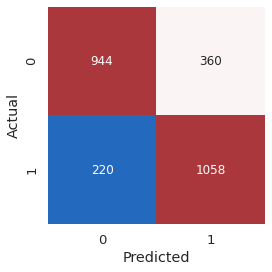

In [ ]:
#import libraries
from sklearn.metrics import confusion_matrix

#define CM object
confusion_matrix = confusion_matrix(Y_test, predictions)
df_cm = pd.DataFrame(confusion_matrix, columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#plot the CM result
plt.figure(figsize = (4,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12}, cbar=False,
          vmax=500, square=True, fmt="d", cmap="vlag")# font size

### Comments:
- From the confusion matrix, it is evident that the model can predict positive (customers who actually stopped) more accurately than negative (customers who still use the service), with the True Positive and True Nagtive proportion being bigger than that of False Positive and False Negative (1058/220 > 944/360)
- Our model performs very well in predicting both churn and active customers. 

## 7.3 Classification Report

In [ ]:
from sklearn.metrics import classification_report
#get classification report
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1304
           1       0.75      0.83      0.78      1278

    accuracy                           0.78      2582
   macro avg       0.78      0.78      0.77      2582
weighted avg       0.78      0.78      0.77      2582

